## Create df for all station 

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read .csv

In [53]:
input_file = "dataset.csv"
output_file = "cleaned_dataset.csv"
df = pd.read_csv("dataset.csv", delimiter=";")

print(f"len before: {len(df)}")

len before: 10840


# drop duplicates

In [54]:
before_count = len(df)
df = df.drop_duplicates()
after_count = len(df)

    Check format of 'Date' column.

In [55]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m", errors="coerce")

    Check inter/national

In [56]:
target_services = ["National", "International"]
df["Service"] = df["Service"].apply(lambda x: x if x in target_services else pd.NA)

df = df.dropna(subset=["Service"])
print(f"len after: {len(df)}")

len after: 9833


# Open the list of train station

In [57]:
stations = pd.read_csv("list.csv", delimiter=";")

# Cleaning Station Names with Levenshtein Distance

In this section, we use the Levenshtein distance algorithm to standardize train station names in our dataset. This technique helps handle spelling errors, format variations, or typos in station names.

## The Levenshtein Algorithm

The Levenshtein distance measures the difference between two strings by counting the minimum number of single-character operations (insertions, deletions, and substitutions) needed to transform one string into another.

For example, the distance between "PARIS" and "PARES" is 1 (one substitution of 'I' to 'E').

## Our Two-Step Approach

1. **Distance Calculation**: For each station name not in our reference list, we calculate the Levenshtein distance with all known stations.

2. **Matching**: We replace the name with its closest match if the distance is less than or equal to our threshold (default: 3 characters).

This method allows us to standardize departure and arrival station names, facilitating subsequent analysis by line or by station.

In [58]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]


def find_closest_match(name, target_list, max_distance=3):
    if not name or not isinstance(name, str):
        return ""
    name = name.upper()
    best_match = ""
    min_distance = float("inf")

    for target in target_list:
        target_upper = target.upper()
        dist = levenshtein_distance(name, target_upper)
        if dist < min_distance:
            min_distance = dist
            best_match = target
    if min_distance <= max_distance:
        return best_match
    return ""


target_cities = stations["name"].tolist()
df["Departure station"] = df["Departure station"].apply(
    lambda x: x if x in target_cities else find_closest_match(x, target_cities)
)
df["Arrival station"] = df["Arrival station"].apply(
    lambda x: x if x in target_cities else find_closest_match(x, target_cities)
)
df["Departure station"] = df["Departure station"].replace("", pd.NA)
df["Arrival station"] = df["Arrival station"].replace("", pd.NA)

## Limiting Outliers in Numeric Columns

In this section, we cap extreme values (outliers) in selected numeric columns at the 75th percentile (third quartile).


## Why ?

- We noticed thanks to our QM score metric that when training the model, marginal values ​​(greater than 75%) distorted the dataset.
- So, to reduce the influence of unusually high values on subsequent analyses we reduce the values ​​greater than 75% of the median to the third quartile



In [59]:
columns_to_clip = [
    "Number of trains delayed > 60min",
    "Number of cancelled trains",
    "Number of trains delayed at arrival",
    "Average delay of all trains at departure",
    "Average delay of late trains at arrival",
]

for col in columns_to_clip:
    quantile3 = df[col].quantile(0.75)
    mean = df[col].mean()
    df[col] = df[col].clip(None, quantile3)

## Replacement of missing values and conversion of numeric columns
    In this section, we will replace missing values with default values (such as pd.NA, a NULL value) and convert numeric columns to appropriate types to facilitate further analysis.

# Replace NA
    replace N/A values by the confidence interval

In [60]:
confidence = 0.95

delay_columns = [
    "Average delay of trains > 15min (if competing with flights)",
    "Average delay of all trains at departure",
    "Average delay of late trains at departure",
    "Average delay of late trains at arrival",
    "Average delay of all trains at arrival",
]

numeric_columns = [
    "Number of scheduled trains",
    "Number of cancelled trains",
    "Number of trains delayed at departure",
    "Number of trains delayed at arrival",
    "Number of trains delayed > 15min",
    "Number of trains delayed > 30min",
    "Number of trains delayed > 60min",
]

for col in delay_columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(0).astype(int)

confidence_intervals = {}
for col in delay_columns:
    data = df[col].dropna()
    n = len(data)
    if n > 1:
        mean = data.mean()
        std = data.std(ddof=1)
        sem = std / np.sqrt(n)
        t = 2 if n > 30 else 2.13
        margin = t * sem
        confidence_intervals[col] = (mean - margin, mean + margin)
    else:
        confidence_intervals[col] = (None, None)

for col in delay_columns:
    mean_value = df[col].mean(skipna=True)
    df[col] = df[col].fillna(mean_value)

## Add season column
    in function of month, we create a column who give us the season

In [61]:
month_to_season = {
    12: "Winter",
    1: "Winter",
    2: "Winter",
    3: "Spring",
    4: "Spring",
    5: "Spring",
    6: "Summer",
    7: "Summer",
    8: "Summer",
    9: "Autumn",
    10: "Autumn",
    11: "Autumn",
}
df["Season"] = df["Date"].dt.month.map(month_to_season).astype("category")
df["Month"] = df["Date"].dt.month
df["Month"] = df["Month"].fillna(1).astype(int)
df["Year"] = df["Date"].dt.year
df["Year"] = df["Year"].fillna(2018).astype(int)

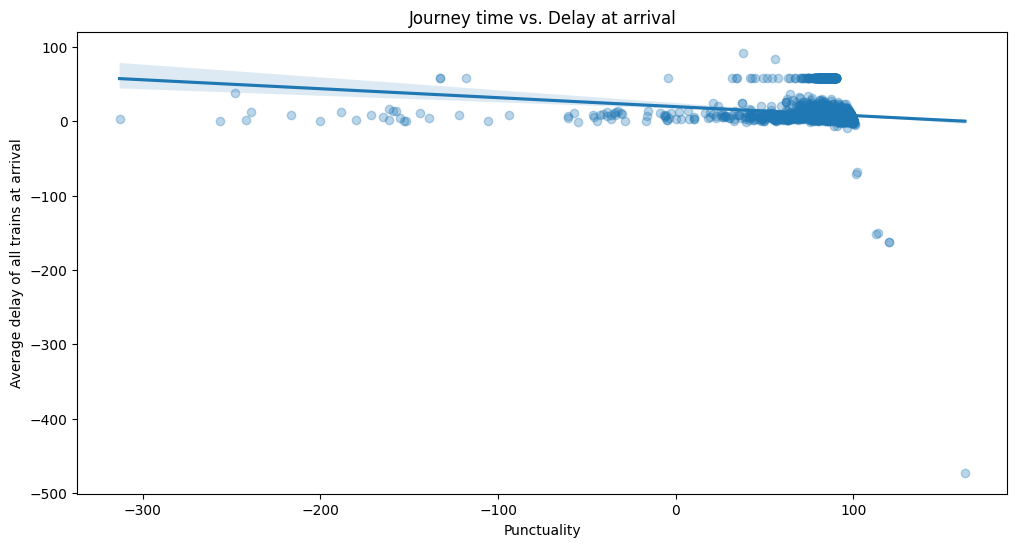

In [62]:
df = df[df["Number of scheduled trains"] > 0]

df["Punctuality"] = (
    100
    - 40 * (df["Number of cancelled trains"] / df["Number of scheduled trains"])
    - 30 * (df["Number of trains delayed > 15min"] / df["Number of scheduled trains"])
    - 20
    * (df["Number of trains delayed at arrival"] / df["Number of scheduled trains"])
    - 10 * (df["Average delay of all trains at arrival"] / 60)
)
plt.figure(figsize=(12, 6))
sns.regplot(
    data=df,
    x="Punctuality",
    y="Average delay of all trains at arrival",
    scatter_kws={"alpha": 0.3},
)
plt.title("Journey time vs. Delay at arrival")
plt.show()

# Add delay gap column

for correlation in function of retards

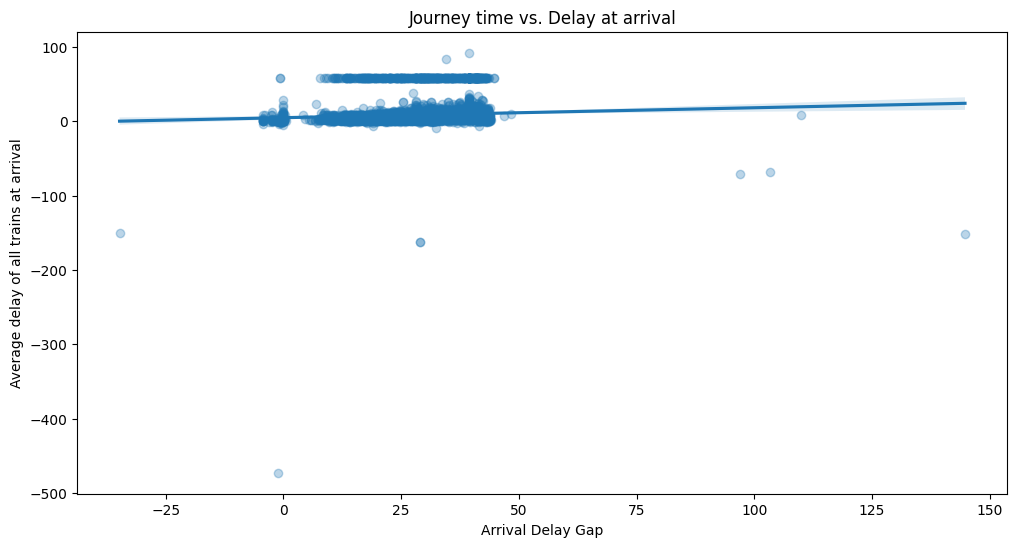

In [63]:
df["Arrival Delay Gap"] = (
    df["Average delay of late trains at arrival"]
    - df["Average delay of all trains at departure"]
)

df["Departure Delay Gap"] = (
    df["Average delay of all trains at departure"]
    - df["Average delay of late trains at arrival"]
)

plt.figure(figsize=(12, 6))
sns.regplot(
    data=df,
    x="Arrival Delay Gap",
    y="Average delay of all trains at arrival",
    scatter_kws={"alpha": 0.3},
)
plt.title("Journey time vs. Delay at arrival")
plt.show()

## Create a NON-delayed trains column
    In function of month, we create a column who give us the number of train non delayed at arrival and at departure and total

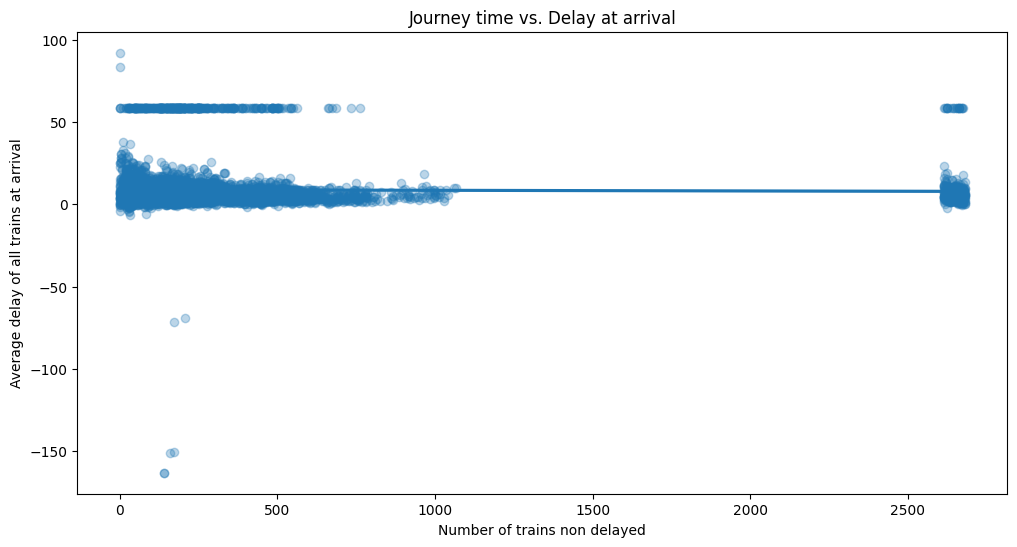

In [64]:
non_delayed_trains = (
    df["Number of scheduled trains"]
    - df["Number of cancelled trains"]
    - df["Number of trains delayed at arrival"]
)
df["Number of trains non delayed"] = non_delayed_trains.clip(lower=0)

percent_delayed = (
    df["Number of trains delayed at arrival"] / df["Number of scheduled trains"]
) * 100
df["Percent of trains delayed"] = percent_delayed.fillna(0).clip(lower=0, upper=100)

df["Route"] = df["Departure station"] + " → " + df["Arrival station"]

df["Date_str"] = df["Date"].dt.strftime("%Y-%m")
df = df.drop(columns=["Date"])
df = df.rename(columns={"Date_str": "Date"})

df = df.dropna(
    subset=[
        "Departure station",
        "Arrival station",
        "Date",
        "Average delay of late trains at arrival",
    ]
)

plt.figure(figsize=(12, 6))
sns.regplot(
    data=df,
    x="Number of trains non delayed",
    y="Average delay of all trains at arrival",
    scatter_kws={"alpha": 0.3},
)
plt.title("Journey time vs. Delay at arrival")
plt.show()

df.sort_values(by=["Route", "Date"], inplace=True)

# Replace order in Dataframe
    del line with bad values

In [65]:
cols = df.columns.tolist()
cols.remove("Date")
cols.remove("Season")
cols.remove("Month")
cols.remove("Year")
cols = ["Date", "Season", "Month", "Year"] + cols
df = df[cols]

# Creating Route columns

    this columns is for have the entiere Rute name

In [66]:
routes_db = {}

for route in df["Route"].unique():
    route_data = df[df["Route"] == route].copy()
    route_data = route_data.sort_values("Date")
    routes_db[route] = route_data

df = df.drop_duplicates(subset=["Route", "Date"])
print(f"Nombre de trajets uniques: {len(routes_db)}")

Nombre de trajets uniques: 130


# Creating dataset with comments only

In [67]:
comment_columns = [
    "Cancellation comments",
    "Departure delay comments",
    "Arrival delay comments",
]

existing_comment_cols = [col for col in comment_columns if col in df.columns]

if existing_comment_cols:
    comments_df = df[
        [
            "Date",
            "Departure station",
            "Arrival station",
            "Route",
            "Pct delay due to external causes",
            "Pct delay due to rolling stock",
            "Pct delay due to infrastructure",
            "Pct delay due to traffic management",
            "Pct delay due to station management and equipment reuse",
            "Pct delay due to passenger handling (crowding, disabled persons, connections)",
        ]
    ].copy()
    comments_df.to_csv("comments_dataset.csv", index=False)
    df = df.drop(columns=existing_comment_cols)
df.to_csv(output_file, index=False)

## Transform dataframe into file.csv
    Here we transform the data rfame into a file .csv, with a seperator: ';'

In [68]:
df.to_csv(output_file, index=False)
print(f"len after: {len(df)}")

len after: 7140
